А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

 

Описание колонок

experimentVariant – вариант эксперимента

version – версия приложения

purchase – факт покупки

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st
import numpy as np
from tqdm.auto import tqdm

sns.set(
    font_scale=1.2
)


In [4]:
data = pd.read_csv('hw_aa.csv', sep=';')
data.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


# Запустите A/A-тест

* Посмотрим каждую группу по отдельности 

In [8]:
group_1 = data.query('experimentVariant == 0')

In [9]:
group_2 = data.query('experimentVariant == 1')

In [14]:
group_1.value_counts().sum()

63102

In [15]:
group_2.value_counts().sum()

63916

## !!

purchase – факт покупки - бинарное выражение

Чтобы посмотреть конверсию, можно взять среднее от всей колонки 

  0%|          | 0/1000 [00:00<?, ?it/s]

0.945

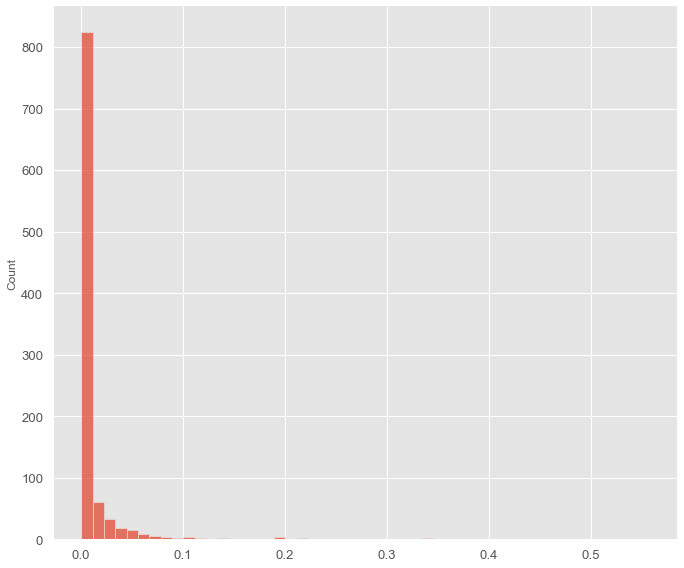

In [81]:
n_s = 1000 #число элементов в эксперементальной выборке из группы 
sim = 1000 #число поторений эксперимента
res = []

for _ in tqdm(range(sim)):
    sample_1 = group_1.purchase.sample(n_s, replace=False).values
    sample_2 = group_2.purchase.sample(n_s, replace=False).values
    res.append(st.ttest_ind(sample_1, sample_2)[1])

sns.displot(res, height=8, aspect=1.2, bins=50)    
    
sum(np.array(res) < 0.05) / sim

### А/А тест показывает, что выборки сильно различаются

# Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента 

* Посмотрим на конверсию для с разных версий приложения

In [91]:
data \
    .groupby(['experimentVariant', 'version'], as_index=False) \
    .agg({'purchase': 'mean'}) \
    .rename(columns={'purchase':'conversion'}) \
    .pivot(index='version', columns='experimentVariant', values='conversion') \
    .reset_index() 

experimentVariant,version,0,1
0,v2.8.0,0.000993,0.045606
1,v2.9.0,0.074658,0.071304
2,v3.7.4.0,0.059943,0.063018
3,v3.8.0.0,0.057604,0.062848


Видим аномальную разницу конверсиями в первой группе

Проведем АА тест отдельно для версии v2.8.0

In [93]:
group_1 = group_1[group_1.version == 'v2.8.0']
group_2 = group_2[group_2.version == 'v2.8.0']

  0%|          | 0/1000 [00:00<?, ?it/s]

1.0

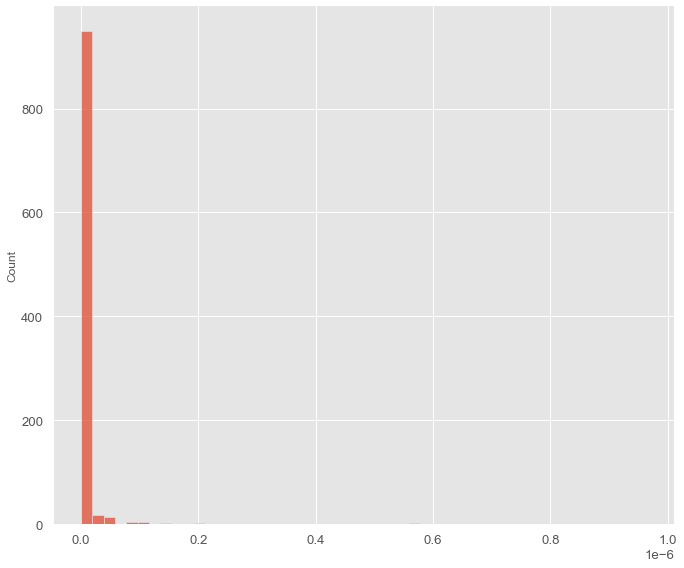

In [94]:
n_s = 1000 #число элементов в эксперементальной выборке из группы 
sim = 1000 #число поторений эксперимента
res = []

for _ in tqdm(range(sim)):
    sample_1 = group_1.purchase.sample(n_s, replace=False).values
    sample_2 = group_2.purchase.sample(n_s, replace=False).values
    res.append(st.ttest_ind(sample_1, sample_2)[1])

sns.displot(res, height=8, aspect=1.2, bins=50)    
    
sum(np.array(res) < 0.05) / sim

# Отличия сильно значимые, поломка именно в этом месте

## !! Правильно будет проверить и остальные версии